In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import mbuild as mb
import parmed
import torch_geometric as tg
from torch_geometric.loader import DataLoader
import shutil
import rdkit
from rdkit import Chem
import mbuild as mb
import torch
from torch import nn, optim

import sys
sys.path.append("/raid6/homes/kierannp/projects/megnn")
from megnn.datasets import *
from megnn.megnn import *
from megnn.utils import *

2023-04-01 14:25:22.678358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 14:25:31.567360: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/mpi/gcc/openmpi-4.1.2/lib
2023-04-01 14:25:31.567458: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/mpi/gcc/openmpi-4.1.2/lib
2023-04-01 14:25:31.567467: W tensorflow/compiler/tf2ten

In [2]:
dat = PdbBind_Dataset(root='/raid6/homes/kierannp/projects/megnn/datasets/v2019-other-PL')

In [6]:
d

PairData(edge_index_s=[2, 206], x_s=[207, 10], positions_s=[207, 3], n_nodes_s=[1], edge_index_t=[2, 25], x_t=[24, 10], positions_t=[24, 3], n_nodes_t=[1], y=[1])

In [14]:
for d in dat:
    if torch.isnan(d.edge_index_s).sum() > 0:
        print(d.edge_index_s)
    if torch.isnan(d.edge_index_t).sum() > 0:
        print(d.edge_index_t)
    if torch.isnan(d.x_s).sum() > 0:
        print(d.x_s)
    if torch.isnan(d.x_t).sum() > 0:
        print(d.x_t)
    if torch.isnan(d.positions_s).sum() > 0:
        print(d.positions_s)
    if torch.isnan(d.positions_t).sum() > 0:
        print(d.positions_t)

In [17]:
y = [float(d.y) for d in dat]

(array([  2.,  12.,  35.,  91., 176., 285., 318., 196.,  56.,  23.]),
 array([-24.3729248 , -21.89508581, -19.41724682, -16.93940783,
        -14.46156884, -11.98372985,  -9.50589086,  -7.02805187,
         -4.55021288,  -2.07237389,   0.4054651 ]),
 <BarContainer object of 10 artists>)

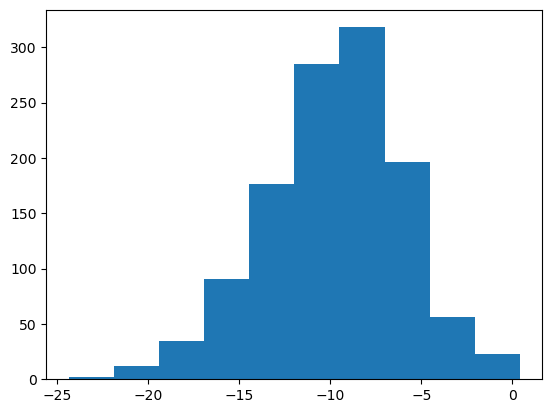

In [18]:
plt.hist(y)

In [12]:
from tabulate import tabulate
print(tabulate(d.x_s))

-  -  -  -  -  -  -  -  -  -------
0  0  0  0  0  0  0  1  0   0.0782
1  0  0  0  0  0  0  0  0   0.22
1  0  0  0  0  0  0  0  0   0.22
1  0  0  0  0  0  0  0  0   0.22
0  0  0  1  0  0  0  0  0   0.0292
1  0  0  0  0  0  0  0  0   0.1141
0  0  0  1  0  0  0  0  0  -0.0235
1  0  0  0  0  0  0  0  0  -0.0169
1  0  0  0  0  0  0  0  0  -0.0169
0  0  0  1  0  0  0  0  0   0.8194
0  0  0  0  0  1  0  0  0  -0.8084
0  0  0  0  0  1  0  0  0  -0.8084
0  0  0  1  0  0  0  0  0   0.5621
0  0  0  0  0  1  0  0  0  -0.5889
0  0  0  0  0  0  0  1  0  -0.4157
1  0  0  0  0  0  0  0  0   0.2719
0  0  0  1  0  0  0  0  0  -0.0875
1  0  0  0  0  0  0  0  0   0.0969
0  0  0  1  0  0  0  0  0   0.2985
1  0  0  0  0  0  0  0  0  -0.0297
0  0  0  1  0  0  0  0  0  -0.3192
1  0  0  0  0  0  0  0  0   0.0791
1  0  0  0  0  0  0  0  0   0.0791
1  0  0  0  0  0  0  0  0   0.0791
0  0  0  1  0  0  0  0  0  -0.3192
1  0  0  0  0  0  0  0  0   0.0791
1  0  0  0  0  0  0  0  0   0.0791
1  0  0  0  0  0  0  0  0 

In [1]:
# hyperparameters
n_epochs  = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
batch_size = 16

# dataset
dat = PdbBind_Dataset(root='/raid6/homes/kierannp/projects/megnn/datasets/v2019-other-PL')
dat.shuffle()
train_dataset = dat[:int(len(dat)*.8)]
test_dataset = dat[int(len(dat)*.8):]
train_loader = DataLoader(train_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=False)

# model
model = MEGNN(n_graphs=2, in_node_nf=110, in_edge_nf=0, hidden_nf=256, device=device, n_layers=8, coords_weight=1.,
             attention=True, node_attr=1)
model.load_state_dict(torch.load('../models/MEGNN_2023-02-14 12:02:01.022340.pth', map_location=device))
model.eval()

# optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

NameError: name 'torch' is not defined

In [9]:
predictions, actuals = [], []
for i, data in enumerate(train_loader):
    conversion = convert_to_dense(data, device, dtype)

    one_hot_s = conversion[0]
    one_hot_t = conversion[1]
    edges_s = conversion[2]
    edges_t = conversion[3]
    atom_mask_s = conversion[4]
    atom_mask_t = conversion[5]
    edge_mask_s = conversion[6]
    edge_mask_t = conversion[7]
    n_nodes_s = conversion[8]
    n_nodes_t = conversion[9]
    atom_positions_s = conversion[10]
    atom_positions_t = conversion[11]
    batch_size_s = conversion[12]
    label = conversion[13]

    pred = model(
        h0 = [one_hot_s, one_hot_t], 
        all_edges = [edges_s, edges_t], 
        all_edge_attr = [None, None], 
        node_masks = [atom_mask_s, atom_mask_t], 
        edge_masks = [edge_mask_s, edge_mask_t],
        n_nodes = [n_nodes_s, n_nodes_t], 
        x = [atom_positions_s, atom_positions_t]
    )
    loss = criterion(pred, label)  # Compute the loss.
    predictions.extend(list(pred.detach().numpy()*dat.std+dat.mean))
    actuals.extend(list(label.detach().numpy()*dat.std+dat.mean))

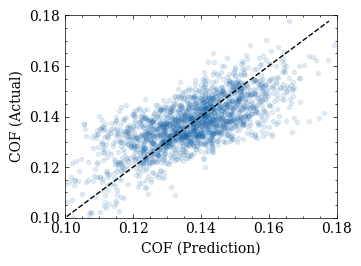

In [10]:
import scienceplots
pparam = dict(xlabel='COF (Prediction)', ylabel='COF (Actual)')

x = np.linspace(0.75, 1.25, 201)

with plt.style.context(['science','no-latex']):
    fig, ax = plt.subplots()
    ax.plot(actuals, predictions, '.',alpha=.1)
    ax.plot(np.linspace(min(predictions), max(predictions),100), np.linspace(min(predictions), max(predictions),100), linestyle='--',color='black')

    # ax.autoscale(tight=True)
    ax.set_xlim(.1,.18)
    ax.set_ylim(.1,.18)
    ax.set(**pparam)
    fig.savefig('megnn.pdf')
    fig.savefig('megnn.jpg', dpi=300)

In [17]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

1956753

# GNN

In [35]:
model = MGNN(n_graphs=2, in_node_nf=110, in_edge_nf=0, hidden_nf=256, device=device, n_layers=8)
model.load_state_dict(torch.load('../models/MGNN_2023-02-09 13:16:02.591261.pth', map_location=device))
model.eval()

MGNN(
  (embedding): Linear(in_features=110, out_features=256, bias=True)
  (gcl_0_0): GCNConv(256, 256)
  (gcl_0_1): GCNConv(256, 256)
  (gcl_0_2): GCNConv(256, 256)
  (gcl_0_3): GCNConv(256, 256)
  (gcl_0_4): GCNConv(256, 256)
  (gcl_0_5): GCNConv(256, 256)
  (gcl_0_6): GCNConv(256, 256)
  (gcl_0_7): GCNConv(256, 256)
  (gcl_1_0): GCNConv(256, 256)
  (gcl_1_1): GCNConv(256, 256)
  (gcl_1_2): GCNConv(256, 256)
  (gcl_1_3): GCNConv(256, 256)
  (gcl_1_4): GCNConv(256, 256)
  (gcl_1_5): GCNConv(256, 256)
  (gcl_1_6): GCNConv(256, 256)
  (gcl_1_7): GCNConv(256, 256)
  (node_dec_0): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (node_dec_1): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (grand_dec): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=Tru

In [37]:
predictions, actuals = [], []
for i, data in enumerate(train_loader):
    pred = model(
        h0 = [data.x_s, data.x_t], 
        all_edges = [data.edge_index_s, data.edge_index_t], 
        all_edge_attr = [None, None], 
        n_nodes = [data.n_nodes_s, data.n_nodes_t], 
        x = [data.positions_s, data.positions_t]
    )
    loss = criterion(pred, data.y)  # Compute the loss.
    predictions.extend(list(pred.detach().numpy()*dat.std+dat.mean))
    actuals.extend(list(data.y.detach().numpy()*dat.std+dat.mean))

In [20]:
import scienceplots
pparam = dict(xlabel='COF (Prediction)', ylabel='COF (Actual)')

with plt.style.context(['science','no-latex']):
    fig, ax = plt.subplots()
    ax.plot(actuals, predictions, '.',alpha=.1)
    ax.plot(np.linspace(min(predictions), max(predictions),100), np.linspace(min(predictions), max(predictions),100), linestyle='--',color='black')

    # ax.autoscale(tight=True)
    ax.set_xlim(.1,.18)
    ax.set_ylim(.1,.18)
    ax.set(**pparam)
    fig.savefig('gnn.pdf')
    fig.savefig('gnn.jpg', dpi=300)

ValueError: x and y must have same first dimension, but have shapes (1904,) and (60,)